SET UP NOTEBOOK

In [42]:
import seaborn as sns

sns.set_context("talk")
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)

SET UP CONSTANTS

In [57]:
labels = ("glioma", "meningioma", "notumor", "pituitary")
img_dim = (512, 512)
test_size = 0.2
random_state = 42
mlr_solver = 'newton-cg'
k_means_algo = 'elkan'
init = 'k-means++'

LOAD/PREPROCESS IMAGES FROM DATASET

In [44]:
import numpy as np
import os
import cv2

def load_images_dataset(label, num_images, img_dim):
    root = os.path.join(os.getcwd(), 'data') # get system path to data folder
    path = os.path.join(root, label) # get path to label folder
    file_paths = os.listdir(path) # list all files

    random_select = np.random.choice(file_paths, num_images, replace=False) # get N random selection of files
    images = []
    for f in random_select:                                                 # Preprocess images
        img_path = os.path.join(path, f)                                    # Get full file path
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)                    # Read image as grayscale
        img = cv2.resize(img, img_dim, interpolation=cv2.INTER_LINEAR)      # Resize image to correct dimensions
        normalized_img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)    # normalize image
        images.append(normalized_img)

    return images

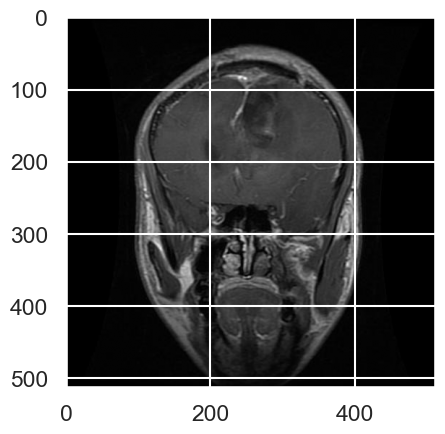

In [45]:
import matplotlib.pyplot as plt

images = load_images_dataset('glioma', 200, img_dim)    # Test Function is Working
plt.imshow(images[1], cmap='gray')                      # Display Image

CONVERT IMAGE LIST TO A DATAFRAME

In [46]:
def convert_images_to_np_array(img_list):
    size = len(img_list)
    num_col = img_list[0].shape[0] * img_list[0].shape[1]   # get number of cols by multiplying dims of first image, all same dim

    for i in range(size):
        img_list[i] =  np.ndarray.flatten(img_list[i]).reshape(num_col, 1)      # flatten image

    img_stack = np.dstack(img_list)                                             # Remove extra axis
    img_stack = np.rollaxis(img_stack, axis = 2, start = 0)
    img_stack = img_stack.reshape(size, num_col)

    return img_stack

In [47]:
from sklearn.utils import shuffle
import pandas as pd

def create_dataframe(num_images):

    df_list = []

    for l in labels:    # for each label
        temp_list = load_images_dataset(l, num_images, img_dim)                 # load images
        temp_array = convert_images_to_np_array(temp_list)                      # convert images to np arraies
        temp_df = pd.DataFrame(temp_array)                                      # convert each array to a df
        temp_df['label'] = l                                                    # add corresponding label to group of images
        df_list.append(temp_df)

    act = pd.concat(df_list, ignore_index=True)         # combine dataframes into one
    final = shuffle(act).reset_index()                  # shuffle images
    final = final.drop(columns=['index'], axis=1)       # drop unneeded index col

    print("Dataframe Created.")

    return final

In [48]:
df = create_dataframe(num_images=2000)  # Test Dataframe was successfully created
print(df.shape)
df.head()                                               # Display First 5 rows

Dataframe Created.
(8000, 262145)


,0,1,2,3,4,5,6,7,8,9,...,262135,262136,262137,262138,262139,262140,262141,262142,262143,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,meningioma
1,0,0,0,0,0,0,0,0,0,0,...,3,3,2,2,1,1,2,2,3,meningioma
2,5,5,4,4,4,5,6,6,1,2,...,0,0,0,0,0,0,0,0,0,pituitary
3,3,3,3,2,2,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,meningioma
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,glioma


SEPERATE IMAGE DATA (X) FROM LABEL DATA (Y)

In [49]:
from sklearn.preprocessing import StandardScaler

def split_x_and_y(df):

    x = df.iloc[:, :-1] # get image data from data frame
    y = df.iloc[:, -1]  # get label data from data frame

    scaler = StandardScaler()               # Scale image data
    x_scaled = scaler.fit_transform(x)

    return (x_scaled, y)

In [50]:
from sklearn.decomposition import PCA

def get_train_and_test(df, pca_on=True):

     x, y = split_x_and_y(df)    # split the image data from the labels
     # Cut down on the features if using pca
     x_reduced = PCA(n_components=4, random_state = random_state).fit_transform(x) if pca_on else x

     return train_test_split(x_reduced, y,test_size = test_size, random_state = random_state)

SUPERVISED LEARNING MODEL (LOGISTIC REGRESSION)

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

def find_best_C(data, solver, penalty='l2', pca_on=True):

    max_iterations = 3000 if pca_on else 100 # Set Max Iterations to higher value if using pca
    l1_ratio = 0.5 if penalty == 'elasticnet' else None

    # Get Training and Test Data
    x_train, x_test, y_train, y_test = data

    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}    # Test out common values for C
    log_reg = LogisticRegression(penalty = penalty, solver = solver, max_iter = max_iterations, l1_ratio = l1_ratio, verbose = 1)

    # Perform Grid Search with Cross-Validation
    grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose = 1)
    grid_search.fit(x_train, y_train)

    # Get the best C value
    return grid_search.best_params_['C']

In [52]:
def multiclass_logistic_regression_pca(data, solver, C, penalty='l2', pca_on = True):

    max_iterations = 3000 if pca_on else 100  # Set Max Iterations to higher value if using pca
    l1_ratio = 0.5 if penalty == 'elasticnet' else None

    # Get Training and Test Data
    x_train, x_test, y_train, y_test = data
    # Train Model
    mlr = LogisticRegression(solver=solver, penalty = penalty, C = C, max_iter = max_iterations, l1_ratio = l1_ratio, verbose = 1)
    mlr.fit(x_train, y_train)

    # Predict Results
    y_pred = mlr.predict(x_test)

    return (y_test, y_pred, mlr)

In [53]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

def mlr_confusion_matrix_and_metrics(y, y_pred, labels):
    # Create confusion matrix
    cm = confusion_matrix(y, y_pred, labels=labels)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Logistic Regression Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y, y_pred, target_names=labels))

    # Print Accuracy
    accuracy = accuracy_score(y, y_pred)
    print(f"\nLogistic Regression accuracy: {accuracy * 100:.2f}%")

In [54]:
data = get_train_and_test(df)       # Get X and Y Train/Test Split

C = find_best_C(data, mlr_solver)   # Find the best C for the Dataset and Solver
print(f"Best C value: {C}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 49.66495331442286 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 15.414718990589233 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 6.00812682469997 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.9733434971067699 <= 0.0001 False
Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 0.13358816692424172 <= 0.0001 False
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.2361875220905467 <= 0.0001 False
Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.12965317433168838 <= 0.0001 False
Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.05349763350403085 <= 0.0001 False
Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.06270907670615555 <= 0.0001 False
Newton-CG iter = 9
  Check Con

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Newton-CG iter = 10
  Check Convergence
    max |gradient| <= tol: 0.04658423186797701 <= 0.0001 False
Newton-CG iter = 11
  Check Convergence
    max |gradient| <= tol: 0.1646329541609944 <= 0.0001 False
Newton-CG iter = 12
  Check Convergence
    max |gradient| <= tol: 0.09121351831390162 <= 0.0001 False
Newton-CG iter = 13
  Check Convergence
    max |gradient| <= tol: 0.010725970728242298 <= 0.0001 False
Newton-CG iter = 14
  Check Convergence
    max |gradient| <= tol: 0.009458116048525913 <= 0.0001 False
Newton-CG iter = 15
  Check Convergence
    max |gradient| <= tol: 0.008411940769144846 <= 0.0001 False
Newton-CG iter = 16
  Check Convergence
    max |gradient| <= tol: 0.012771729868788897 <= 0.0001 False
Newton-CG iter = 17
  Check Convergence
    max |gradient| <= tol: 0.001625078990465982 <= 0.0001 False
Newton-CG iter = 18
  Check Convergence
    max |gradient| <= tol: 0.0009054109915121408 <= 0.0001 False
Newton-CG iter = 19
  Check Convergence
    max |gradient| <= tol: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Newton-CG iter = 16
  Check Convergence
    max |gradient| <= tol: 0.004120236007396735 <= 0.0001 False
Newton-CG iter = 17
  Check Convergence
    max |gradient| <= tol: 0.0013017658465078643 <= 0.0001 False
Newton-CG iter = 18
  Check Convergence
    max |gradient| <= tol: 0.00019630032937559088 <= 0.0001 False
Newton-CG iter = 19
  Check Convergence
    max |gradient| <= tol: 3.1683837538686897e-06 <= 0.0001 True
  Solver did converge at loss = 0.926989013746635.
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 50.28864259740426 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 15.561877920633856 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 6.15919606114772 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.9914362745251661 <= 0.0001 False
Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 0.15809016449711843 <= 0.0001 False
Newton-CG iter = 5
  Check

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 50.308602593725226 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 15.483909180634717 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 6.586155897591258 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 1.0465648196606243 <= 0.0001 False
Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 0.13889456144838105 <= 0.0001 False
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.3182872447667144 <= 0.0001 False
Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.14927271542880402 <= 0.0001 False
Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.049484413367581914 <= 0.0001 False
Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.08915301219994218 <= 0.0001 False
Newton-CG iter = 9
  Check Convergence
    max |gradient| <= tol: 0.042872458600542326 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 50.28864259740426 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 15.561911604171886 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 6.159242874846281 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.9914607833991491 <= 0.0001 False
Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 0.15809598532656086 <= 0.0001 False
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.27416176176585416 <= 0.0001 False
Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.14627414828027732 <= 0.0001 False
Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.05722039255094022 <= 0.0001 False
Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.07387018760446905 <= 0.0001 False
Newton-CG iter = 9
  Check Convergence
    max |gradient| <= tol: 0.03730605730687816 <=

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Newton-CG iter = 17
  Check Convergence
    max |gradient| <= tol: 0.00010857466153793067 <= 0.0001 False
Newton-CG iter = 18
  Check Convergence
    max |gradient| <= tol: 2.4969381774007106e-06 <= 0.0001 True
  Solver did converge at loss = 0.9273904981573493.
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 50.168598946077594 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 15.090003094264933 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 6.468779997048783 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 1.0241787148084047 <= 0.0001 False
Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 0.15815207393688366 <= 0.0001 False
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.27543769743318186 <= 0.0001 False
Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.08464420678772998 <= 0.0001 False
Newton-CG iter = 7
  Check C

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Newton-CG iter = 14
  Check Convergence
    max |gradient| <= tol: 0.009527363717366434 <= 0.0001 False
Newton-CG iter = 15
  Check Convergence
    max |gradient| <= tol: 0.008543950967719385 <= 0.0001 False
Newton-CG iter = 16
  Check Convergence
    max |gradient| <= tol: 0.011850299863934965 <= 0.0001 False
Newton-CG iter = 17
  Check Convergence
    max |gradient| <= tol: 0.0015114661008878226 <= 0.0001 False
Newton-CG iter = 18
  Check Convergence
    max |gradient| <= tol: 0.0008760101293533863 <= 0.0001 False
Newton-CG iter = 19
  Check Convergence
    max |gradient| <= tol: 8.427458074181111e-05 <= 0.0001 True
  Solver did converge at loss = 0.9218451367064915.
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 49.88503752380115 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 15.126338963566912 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 6.436747954315491 <= 0.0001 False
Newton-CG iter = 3
  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Newton-CG iter = 14
  Check Convergence
    max |gradient| <= tol: 0.0038625418486828043 <= 0.0001 False
Newton-CG iter = 15
  Check Convergence
    max |gradient| <= tol: 0.0024928709534376833 <= 0.0001 False
Newton-CG iter = 16
  Check Convergence
    max |gradient| <= tol: 0.0006042748660596919 <= 0.0001 False
Newton-CG iter = 17
  Check Convergence
    max |gradient| <= tol: 9.362233681252566e-05 <= 0.0001 True
  Solver did converge at loss = 0.9305551875034463.
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 49.66495331442286 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 15.415094461735764 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 6.008633478506682 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.973609814478159 <= 0.0001 False
Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 0.13364349360752692 <= 0.0001 False
Newton-CG iter = 5
  Check

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Newton-CG iter = 10
  Check Convergence
    max |gradient| <= tol: 0.12847488649101924 <= 0.0001 False
Newton-CG iter = 11
  Check Convergence
    max |gradient| <= tol: 0.0175909593481539 <= 0.0001 False
Newton-CG iter = 12
  Check Convergence
    max |gradient| <= tol: 0.015318150449944534 <= 0.0001 False
Newton-CG iter = 13
  Check Convergence
    max |gradient| <= tol: 0.017330139137316757 <= 0.0001 False
Newton-CG iter = 14
  Check Convergence
    max |gradient| <= tol: 0.040358847384227785 <= 0.0001 False
Newton-CG iter = 15
  Check Convergence
    max |gradient| <= tol: 0.005073511008613178 <= 0.0001 False
Newton-CG iter = 16
  Check Convergence
    max |gradient| <= tol: 0.0011461996315472545 <= 0.0001 False
Newton-CG iter = 17
  Check Convergence
    max |gradient| <= tol: 0.0008782158132865732 <= 0.0001 False
Newton-CG iter = 18
  Check Convergence
    max |gradient| <= tol: 0.00031261998882741116 <= 0.0001 False
Newton-CG iter = 19
  Check Convergence
    max |gradient| <= t

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 49.66495331442286 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 15.415094495532331 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 6.008633524113563 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.9736098384535261 <= 0.0001 False
Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 0.13364349858876237 <= 0.0001 False
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.23652264892119565 <= 0.0001 False
Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.1298000955312786 <= 0.0001 False
Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.05348168039572341 <= 0.0001 False
Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.06283705670408617 <= 0.0001 False
Newton-CG iter = 9
  Check Convergence
    max |gradient| <= tol: 0.23270942033479522 <= 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Newton-CG iter = 12
  Check Convergence
    max |gradient| <= tol: 0.016693855810640475 <= 0.0001 False
Newton-CG iter = 13
  Check Convergence
    max |gradient| <= tol: 0.024847699273115417 <= 0.0001 False
Newton-CG iter = 14
  Check Convergence
    max |gradient| <= tol: 0.02026041438396082 <= 0.0001 False
Newton-CG iter = 15
  Check Convergence
    max |gradient| <= tol: 0.0054124846972933615 <= 0.0001 False
Newton-CG iter = 16
  Check Convergence
    max |gradient| <= tol: 0.0041438455493001255 <= 0.0001 False
Newton-CG iter = 17
  Check Convergence
    max |gradient| <= tol: 0.0013748925533700815 <= 0.0001 False
Newton-CG iter = 18
  Check Convergence
    max |gradient| <= tol: 0.00020545470684676682 <= 0.0001 False
Newton-CG iter = 19
  Check Convergence
    max |gradient| <= tol: 3.2859417783321804e-06 <= 0.0001 True
  Solver did converge at loss = 0.9269852288088406.
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 50.28864259740426 <= 0.0001 False
Newton-CG i

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.0891861102498903 <= 0.0001 False
Newton-CG iter = 9
  Check Convergence
    max |gradient| <= tol: 0.04289467745653731 <= 0.0001 False
Newton-CG iter = 10
  Check Convergence
    max |gradient| <= tol: 0.03184260431886204 <= 0.0001 False
Newton-CG iter = 11
  Check Convergence
    max |gradient| <= tol: 0.041688982462561586 <= 0.0001 False
Newton-CG iter = 12
  Check Convergence
    max |gradient| <= tol: 0.08871852731078428 <= 0.0001 False
Newton-CG iter = 13
  Check Convergence
    max |gradient| <= tol: 0.04287820741638901 <= 0.0001 False
Newton-CG iter = 14
  Check Convergence
    max |gradient| <= tol: 0.005739885718004825 <= 0.0001 False
Newton-CG iter = 15
  Check Convergence
    max |gradient| <= tol: 0.0036006689239800466 <= 0.0001 False
Newton-CG iter = 16
  Check Convergence
    max |gradient| <= tol: 0.0029060182284143814 <= 0.0001 False
Newton-CG iter = 17
  Check Convergence
    max |gradient| <= tol: 0.0

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [55]:
# Get Y, Predicted Y and Model
y_test, y_pred, mlr = multiclass_logistic_regression_pca(data, C = C, solver = mlr_solver)

Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 50.063166995086206 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 15.335046108119002 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 6.33531323188712 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 1.0094227534203792 <= 0.0001 False
Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 0.13753378953246573 <= 0.0001 False
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.27090989018031747 <= 0.0001 False
Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.1336533349842906 <= 0.0001 False
Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.05216760205382221 <= 0.0001 False
Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.06758116047140744 <= 0.0001 False
Newton-CG iter = 9
  Check Convergence
    max |gradient| <= tol: 0.0360906523914011 <= 0

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


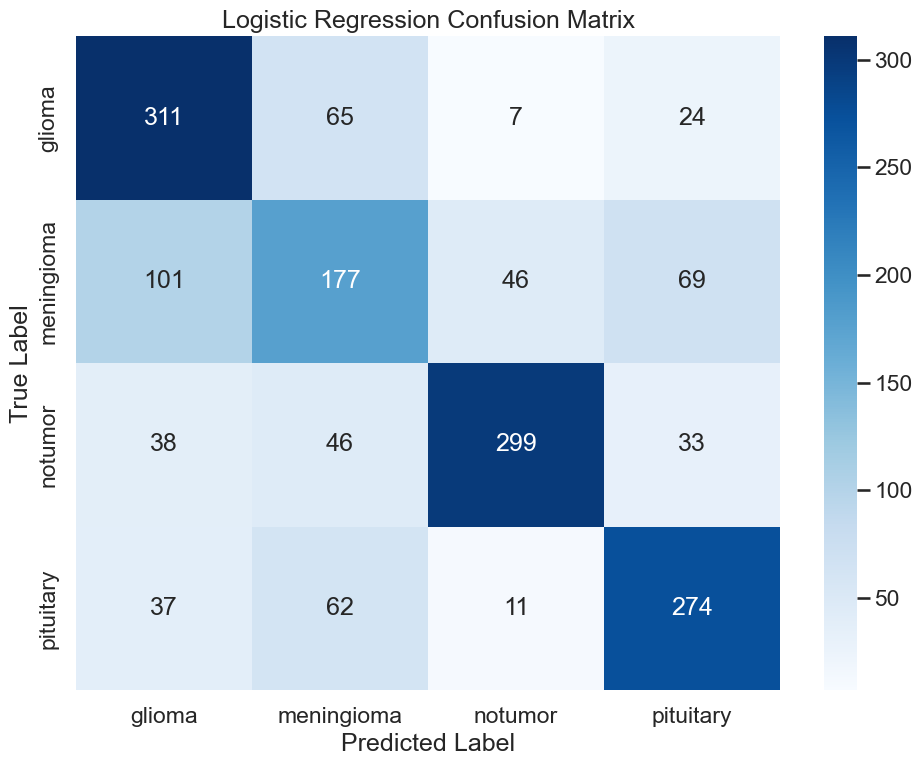


Classification Report:
              precision    recall  f1-score   support

      glioma       0.64      0.76      0.70       407
  meningioma       0.51      0.45      0.48       393
     notumor       0.82      0.72      0.77       416
   pituitary       0.69      0.71      0.70       384

    accuracy                           0.66      1600
   macro avg       0.66      0.66      0.66      1600
weighted avg       0.67      0.66      0.66      1600


Logistic Regression accuracy: 66.31%


In [56]:
# Display Metrics of Model Performance
mlr_confusion_matrix_and_metrics(y_test, y_pred, labels)

UNSUPERVISED LEARNING MODEL (K MEANS)

In [66]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def k_means_pca(x, y, pca_on = True):

    # Reduce Features of X
    x_reduced = PCA(n_components=4, random_state=42).fit_transform(x)

    max_iterations = 3000 if pca_on else 100 # Set Max Iterations to higher value if using pca

    # Apply K-means clustering with 4 clusters (one for each tumor type)
    kmeans_model = KMeans(n_clusters=4, random_state= random_state, max_iter = max_iterations, init = init, algorithm = k_means_algo, verbose = 1)
    kmeans_model.fit(x_reduced)

    # Get cluster predictions
    y_pred_clusters = kmeans_model.predict(x_reduced)

    # Map clusters to actual labels by finding the most common label in each cluster
    cluster_to_label = {}
    for cluster_id in range(4):
        mask = y_pred_clusters == cluster_id
        most_common_label = y[mask].mode()[0]
        cluster_to_label[cluster_id] = most_common_label

    # Map predictions to actual label names
    y_pred_mapped = [cluster_to_label[cluster] for cluster in y_pred_clusters]

    return x_reduced, y, y_pred_mapped, kmeans_model

In [71]:
def kmeans_confusion_matrix_and_metrics(y, y_pred):
    # Create confusion matrix
    cm = confusion_matrix(y, y_pred, labels=labels)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('K Means Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y, y_pred, target_names=labels))

    # Print Accuracy
    accuracy = accuracy_score(y, y_pred)
    print(f"\nK Means accuracy: {accuracy * 100:.2f}%")

In [64]:
from matplotlib.patches import Patch

def visualize_k_means(kmeans_model, y_pred_mapped, x_reduced):
    # Visualize K-means clustering results
    plt.figure(figsize=(12, 8))

    # Create color map for each label
    color_map = {'glioma': 'red', 'meningioma': 'blue', 'notumor': 'green', 'pituitary': 'orange'}
    colors = [color_map[label] for label in y_pred_mapped]

    # Plot the first two principal components
    scatter = plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=colors, alpha=0.6, s=50)

    # Plot cluster centers
    centers = kmeans_model.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, alpha=0.8, marker='X', edgecolors='white', linewidths=2, label='Centroids')

    # Add legend
    legend_elements = [Patch(facecolor=color_map[label], label=label) for label in labels]
    legend_elements.append(plt.Line2D([0], [0], marker='X', color='w', markerfacecolor='black', markersize=15, label='Centroids'))
    plt.legend(handles=legend_elements, loc='best')

    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('K-means Clustering Results (PCA Visualization)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [69]:
# Train K Means Model
x, y = split_x_and_y(df)
x_reduced, y, y_pred_mapped, kmeans_model = k_means_pca(x, y)

Initialization complete
Iteration 0, inertia 449318530.4102728
Iteration 1, inertia 381694767.4886448
Iteration 2, inertia 352022021.4526372
Iteration 3, inertia 331593936.316509
Iteration 4, inertia 319143176.7249152
Iteration 5, inertia 313191868.0852302
Iteration 6, inertia 310188277.55164385
Iteration 7, inertia 307605156.81571364
Iteration 8, inertia 304479731.03780097
Iteration 9, inertia 301210867.3564494
Iteration 10, inertia 298967894.5194905
Iteration 11, inertia 297999937.98073226
Iteration 12, inertia 297603582.17224395
Iteration 13, inertia 297497582.86277
Iteration 14, inertia 297469393.4356657
Iteration 15, inertia 297456379.2363779
Iteration 16, inertia 297448702.28590614
Iteration 17, inertia 297432461.47937465
Iteration 18, inertia 297414819.86784756
Iteration 19, inertia 297400145.54550177
Iteration 20, inertia 297379152.94241154
Iteration 21, inertia 297369906.71942323
Iteration 22, inertia 297354420.14377534
Iteration 23, inertia 297349765.57569027
Iteration 24, in

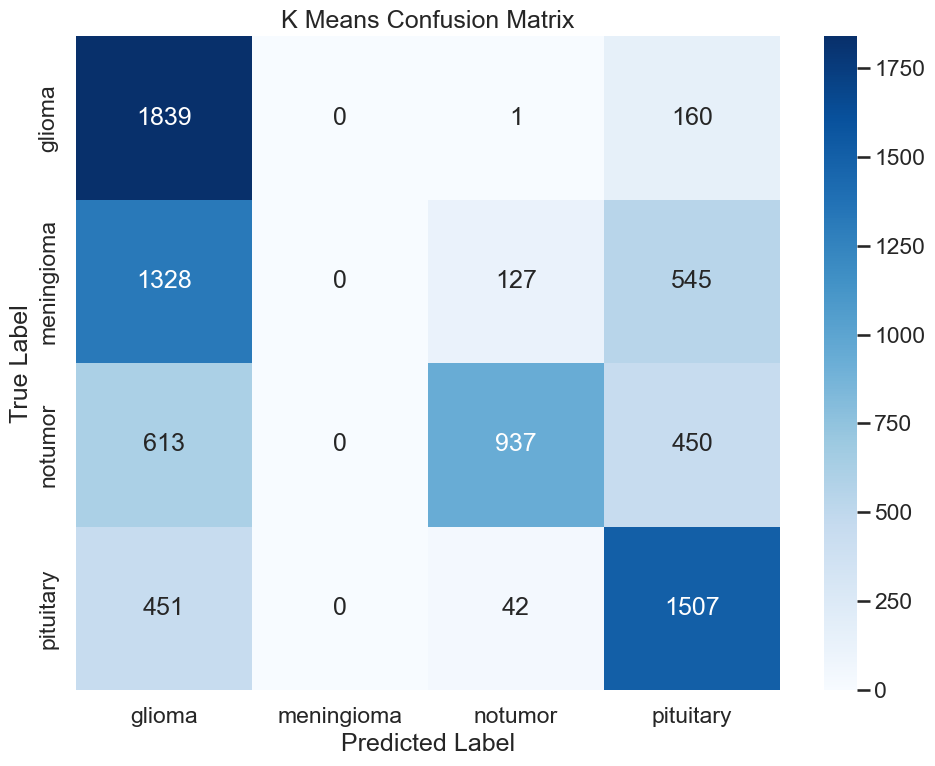


Classification Report:
              precision    recall  f1-score   support

      glioma       0.43      0.92      0.59      2000
  meningioma       0.00      0.00      0.00      2000
     notumor       0.85      0.47      0.60      2000
   pituitary       0.57      0.75      0.65      2000

    accuracy                           0.54      8000
   macro avg       0.46      0.54      0.46      8000
weighted avg       0.46      0.54      0.46      8000


K Means accuracy: 53.54%


C:\Users\Ash\PycharmProjects\JupyterProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Ash\PycharmProjects\JupyterProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Ash\PycharmProjects\JupyterProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [72]:
# Display Metrics of Model Performance
kmeans_confusion_matrix_and_metrics(y, y_pred_mapped)

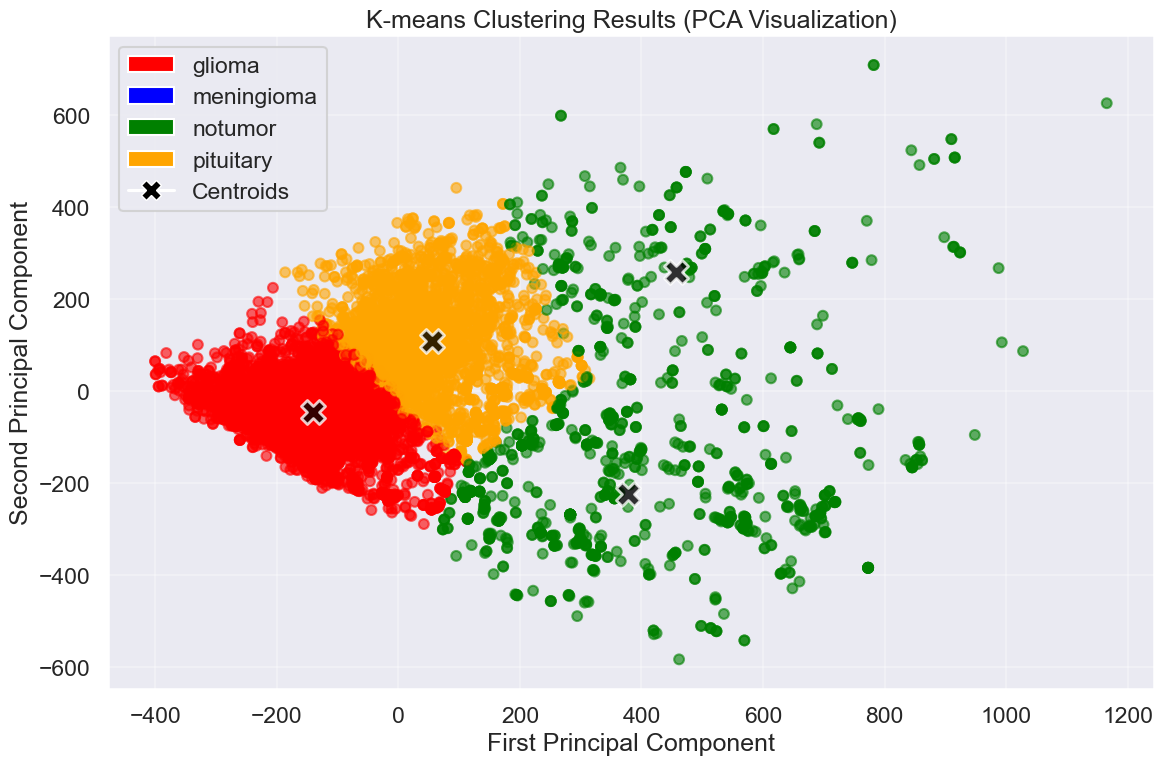

In [73]:
# Visualize K means Clusters
visualize_k_means(kmeans_model, y_pred_mapped, x_reduced)